In [1]:
import geopandas as gpd
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

In [29]:
felyxotp = pd.read_pickle('OTPFused/felyxfused5')
PCs = gpd.read_file('../PublicGeoJsons/AmsPCs.json')
pcdata = pd.read_pickle('../PostcodeInfo/PCData')
pcdata.index.names = ['pc4']
pcdata = pcdata.reset_index()

In [30]:
felyxotp = felyxotp.dropna()

In [31]:
felyxotp = felyxotp.replace({-3: np.nan})
felyxotp.head()

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,distancemoved,prev_fl,pt_dur,pt_dist,walk_dur,walk_dist,bike_dur,bike_dist,car_dur,car_dist
0,0,853,38,2023-01-02 18:50:40,52.358633,4.859237,POINT (4.85924 52.35863),2023-01-02 17:29:36,0 days 01:21:04,POINT (4.88286 52.37315),0.027727,47.0,1546.0,4322.755343,2153.0,2709.743,650.0,2769.306,781.0,3774.392
100012,100012,3861,36,2023-02-20 16:29:52,52.342205,4.845916,POINT (4.84592 52.34220),2023-02-20 16:19:12,0 days 00:10:40,POINT (4.84340 52.34237),0.002521,37.0,139.0,176.177000,139.0,176.177,174.0,674.242,47.0,176.177
100013,100013,3861,30,2023-02-20 18:05:52,52.358066,4.877993,POINT (4.87799 52.35807),2023-02-20 17:50:56,0 days 00:14:56,POINT (4.84590 52.34239),0.035717,36.0,1684.0,3817.581223,2444.0,3123.268,726.0,3184.514,747.0,3342.194
100023,100023,3861,51,2023-02-24 21:30:40,52.358823,4.920905,POINT (4.92091 52.35882),2023-02-24 21:22:08,0 days 00:08:32,POINT (4.91869 52.34938),0.009695,54.0,756.0,1556.957956,1140.0,1435.704,369.0,1614.903,389.0,1658.771
10004,10004,1187,96,2023-01-13 11:22:40,52.332980,4.914108,POINT (4.91411 52.33298),2023-01-13 10:46:24,0 days 00:36:16,POINT (4.87396 52.36492),0.051303,15.0,2426.0,7308.550507,4115.0,5198.888,1223.0,5243.968,1211.0,6162.777


In [5]:
# felyxotp[felyxotp.walk_dist.isna()]

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,distancemoved,prev_fl,pt_dur,pt_dist,walk_dur,walk_dist,bike_dur,bike_dist,car_dur,car_dist
100475,100475,3938,99,2023-02-28 21:49:52,52.390478,4.885927,POINT (4.88593 52.39048),2023-02-28 21:34:56,0 days 00:14:56,POINT (4.90415 52.37464),0.024144,91.0,1097.0,2798.504242,NaN,NaN,631.0,2624.663,931.0,4932.799
103050,103050,6398,90,2023-02-23 15:04:32,52.347605,4.905944,POINT (4.90594 52.34761),2023-02-23 14:06:56,0 days 00:57:36,POINT (4.90661 52.34779),0.000691,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103453,103453,6405,28,2023-02-06 16:19:12,52.354482,4.856556,POINT (4.85656 52.35448),2023-02-06 16:06:24,0 days 00:12:48,POINT (4.82870 52.34295),0.030149,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103721,103721,6409,52,2023-02-23 07:45:04,52.394538,4.872368,POINT (4.87237 52.39454),2023-02-23 07:28:00,0 days 00:17:04,POINT (4.92783 52.37552),0.058632,57.0,NaN,NaN,NaN,NaN,NaN,NaN,721.0,4839.883
107371,107371,6553,63,2023-02-22 08:46:56,52.372570,4.918048,POINT (4.91805 52.37257),2023-02-21 20:20:16,0 days 12:26:40,POINT (4.95074 52.35446),0.037373,76.0,1661.0,4294.207241,NaN,NaN,890.0,3712.332,891.0,3987.660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95736,95736,2740,24,2023-02-01 18:44:16,52.342913,4.828678,POINT (4.82868 52.34291),2023-02-01 18:40:00,0 days 00:04:16,POINT (4.82789 52.34659),0.003760,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96739,96739,3120,72,2023-02-01 08:29:52,52.334343,4.857019,POINT (4.85702 52.33434),2023-02-01 08:04:16,0 days 00:25:36,POINT (4.87056 52.36761),0.035921,77.0,1899.0,6055.533414,NaN,NaN,1040.0,4515.338,1013.0,8317.740
97182,97182,3243,27,2023-02-14 21:45:36,52.355059,4.955924,POINT (4.95592 52.35506),2023-02-14 18:42:08,0 days 03:03:28,POINT (4.95777 52.29745),0.057637,39.0,2600.0,10981.691601,NaN,NaN,1966.0,8343.102,1174.0,11381.922
99165,99165,3727,89,2023-02-06 09:21:04,52.365243,4.905287,POINT (4.90529 52.36524),2023-02-06 09:10:24,0 days 00:10:40,POINT (4.91943 52.34596),0.023914,91.0,964.0,3037.770864,NaN,NaN,613.0,2478.004,694.0,2549.585


In [6]:
# felyxotp[felyxotp.isna()]

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,distancemoved,prev_fl,pt_dur,pt_dist,walk_dur,walk_dist,bike_dur,bike_dist,car_dur,car_dist
0,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100012,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100013,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99939,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99949,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99991,NaN,NaN,NaN,NaT,NaN,NaN,None,NaT,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
felyxotp = felyxotp.dropna()

In [33]:
from datetime import timedelta
felyxotp = felyxotp[felyxotp.timedelta < timedelta(minutes = 100)]
felyxotp = felyxotp[felyxotp.timedelta > timedelta(minutes = 2)]
mean = felyxotp['distancemoved'].mean()
std = felyxotp['distancemoved'].std()
# felyxotp = felyxotp[np.abs(felyxotp['distancemoved'] - mean) <= 2.5 * std]
felyxotp = felyxotp[felyxotp['walk_dist']  >= 500]

felyxotp.head()

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,distancemoved,prev_fl,pt_dur,pt_dist,walk_dur,walk_dist,bike_dur,bike_dist,car_dur,car_dist
0,0,853,38,2023-01-02 18:50:40,52.358633,4.859237,POINT (4.85924 52.35863),2023-01-02 17:29:36,0 days 01:21:04,POINT (4.88286 52.37315),0.027727,47.0,1546.0,4322.755343,2153.0,2709.743,650.0,2769.306,781.0,3774.392
100013,100013,3861,30,2023-02-20 18:05:52,52.358066,4.877993,POINT (4.87799 52.35807),2023-02-20 17:50:56,0 days 00:14:56,POINT (4.84590 52.34239),0.035717,36.0,1684.0,3817.581223,2444.0,3123.268,726.0,3184.514,747.0,3342.194
100023,100023,3861,51,2023-02-24 21:30:40,52.358823,4.920905,POINT (4.92091 52.35882),2023-02-24 21:22:08,0 days 00:08:32,POINT (4.91869 52.34938),0.009695,54.0,756.0,1556.957956,1140.0,1435.704,369.0,1614.903,389.0,1658.771
10004,10004,1187,96,2023-01-13 11:22:40,52.332980,4.914108,POINT (4.91411 52.33298),2023-01-13 10:46:24,0 days 00:36:16,POINT (4.87396 52.36492),0.051303,15.0,2426.0,7308.550507,4115.0,5198.888,1223.0,5243.968,1211.0,6162.777
100052,100052,3864,83,2023-02-22 11:48:16,52.352930,4.892640,POINT (4.89264 52.35293),2023-02-22 11:29:04,0 days 00:19:12,POINT (4.86214 52.33649),0.034649,85.0,1312.0,4469.387844,2773.0,3491.763,824.0,3515.907,822.0,3947.277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99924,99924,3841,67,2023-02-25 17:21:04,52.390913,4.855753,POINT (4.85575 52.39091),2023-02-25 16:55:28,0 days 00:25:36,POINT (4.88460 52.36111),0.041477,71.0,2285.0,5990.469853,3862.0,4834.795,1148.0,4924.364,1213.0,8228.534
9993,9993,1187,56,2023-01-11 18:44:16,52.379941,4.878371,POINT (4.87837 52.37994),2023-01-11 18:31:28,0 days 00:12:48,POINT (4.87132 52.38166),0.007258,57.0,616.0,759.554000,616.0,759.554,192.0,790.567,227.0,1049.888
99939,99939,3851,27,2023-02-17 11:12:00,52.341860,4.919005,POINT (4.91901 52.34186),2023-02-17 10:46:24,0 days 00:25:36,POINT (4.86923 52.33553),0.050176,34.0,1607.0,5643.515482,3450.0,4314.994,1018.0,4314.009,918.0,6952.186
99991,99991,3861,75,2023-02-17 16:38:24,52.378958,4.893856,POINT (4.89386 52.37896),2023-02-17 16:29:52,0 days 00:08:32,POINT (4.85100 52.37035),0.043712,80.0,1252.0,3750.963471,2746.0,3435.885,863.0,3579.021,984.0,4454.124


In [34]:
felyxotp['seconds'] = felyxotp.time.dt.second + 60*(felyxotp.time.dt.hour)

In [35]:
felyxotp['hour'] = felyxotp.time.dt.hour
felyxotp['weekdag'] = felyxotp.time.dt.dayofweek
seconds_in_day = 24*60*60
felyxotp['sin_time'] = np.sin(2*np.pi*felyxotp.seconds/seconds_in_day)
felyxotp['cos_time'] = np.cos(2*np.pi*felyxotp.seconds/seconds_in_day)
felyxotp = felyxotp.drop([ 'seconds'], axis = 1)

In [36]:
len(felyxotp)

18465

In [37]:
felyxotp = felyxotp.join(
    gpd.GeoDataFrame(
        felyxotp[['prev_location']], geometry=felyxotp[['prev_location']].prev_location,
        crs='EPSG:4326'
    ).drop('prev_location', axis=1).sjoin(PCs.rename(columns={'Postcode4': 'vertpc'})).vertpc
)
felyxotp = felyxotp.join(
    gpd.GeoDataFrame(
        felyxotp, geometry=felyxotp.geometry,
        crs='EPSG:4326'
    ).sjoin(PCs.rename(columns={'Postcode4': 'aankpc'})).aankpc
)

In [38]:
# felyxotp[['hour','vertpc','aankpc']] = felyxotp[['hour','vertpc','aankpc']].astype(str)
felyxotp[['vertpc','aankpc']] = felyxotp[['vertpc','aankpc']].astype(str)

In [39]:
len(felyxotp)

18465

In [40]:
felyxotp.weekdag = felyxotp.weekdag.replace({0:'Maandag', 1:'Dinsdag', 2:'Woensdag', 3:'Donderdag', 4:'Vrijdag', 5:'Zaterdag', 6:'Zondag'})

In [41]:
felyxotp['oprijbewijsau'] = [1] * len(felyxotp)

In [42]:
felyxotp = felyxotp.merge(pcdata.add_prefix('aank '), left_on = 'aankpc', right_on = 'aank pc4')
felyxotp = felyxotp.merge(pcdata.add_prefix('vert '), left_on = 'vertpc', right_on = 'vert pc4')
felyxotp = felyxotp.drop(['aank pc4', 'vert pc4'], axis = 1)

In [43]:
felyxotp.head()

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,...,vert 2005 tot 2015,vert 2015 en later,vert Meergezins,vert Koopwoning,vert Huurwoning,vert Huurcoporatie,vert Niet bewoond,vert WOZ-waarde\nwoning,"vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd",vert density
0,0,853,38,2023-01-02 18:50:40,52.358633,4.859237,POINT (4.85924 52.35863),2023-01-02 17:29:36,0 days 01:21:04,POINT (4.88286 52.37315),...,0.010221,0.016077,0.656605,0.000539,0.000449,0.144962,0.045665,0.000264,0.064323,0.978307
1,104115,6412,22,2023-02-28 13:00:48,52.361151,4.873966,POINT (4.87397 52.36115),2023-02-28 12:09:36,0 days 00:51:12,POINT (4.88215 52.36602),...,0.010221,0.016077,0.656605,0.000539,0.000449,0.144962,0.045665,0.000264,0.064323,0.978307
2,109658,6591,69,2023-02-05 02:08:00,52.359987,4.861473,POINT (4.86147 52.35999),2023-02-05 01:40:16,0 days 00:27:44,POINT (4.87676 52.37383),...,0.010221,0.016077,0.656605,0.000539,0.000449,0.144962,0.045665,0.000264,0.064323,0.978307
3,117392,8147,89,2023-02-06 16:51:12,52.363555,4.875191,POINT (4.87519 52.36355),2023-02-06 16:36:16,0 days 00:14:56,POINT (4.88268 52.36742),...,0.010221,0.016077,0.656605,0.000539,0.000449,0.144962,0.045665,0.000264,0.064323,0.978307
4,128180,1039,29,2023-03-25 02:22:06,52.361322,4.864722,POINT (4.86472 52.36132),2023-03-25 02:01:06,0 days 00:21:00,POINT (4.88230 52.36639),...,0.010221,0.016077,0.656605,0.000539,0.000449,0.144962,0.045665,0.000264,0.064323,0.978307


In [45]:
felyxotp.to_pickle('felyxotp')

In [44]:
for col in felyxotp.columns:
    print(col)

tripid
carId
fuelLevel
time
lat
lon
geometry
prev_time
timedelta
prev_location
distancemoved
prev_fl
pt_dur
pt_dist
walk_dur
walk_dist
bike_dur
bike_dist
car_dur
car_dist
hour
weekdag
sin_time
cos_time
vertpc
aankpc
oprijbewijsau
aank Totaal
aank Man
aank Vrouw
aank tot 15 jaar
aank 15 tot 25 jaar
aank 25 tot 45 jaar
aank 45 tot 65 jaar
aank 65 jaar en ouder
aank Geboren in Nederland met een Nederlandse herkomst
aank Geboren in Nederland met een Europese herkomst (excl. Nederland)
aank Geboren in Nederland met herkomst buiten Europa
aank Geboren buiten Nederland met een Europese herkomst (excl. Nederland)
aank Geboren buiten Nederland met een herkomst buiten Europa
aank Totaal.1
aank Eenpersoons
aank Meerpersoons 
zonder kinderen
aank Eenouder
aank Tweeouder
aank Huishoudgrootte
aank Totaal.2
aank voor 1945
aank 1945 tot 1965
aank 1965 tot 1975
aank 1975 tot 1985
aank 1985 tot 1995
aank 1995 tot 2005
aank 2005 tot 2015
aank 2015 en later
aank Meergezins
aank Koopwoning
aank Huurwoning


In [2]:
test_data = pd.read_pickle('felyxotp')

In [3]:
train_data = pd.read_pickle('../Odin/Odin2019Ams')

In [4]:
train_data['weekdag'] = train_data['weekdag'].replace(
    {1:6, 2:0, 3:1, 4:2, 5:3, 6:4, 7:5})

In [5]:
choice_dict = pd.read_json('../Odin/OdinData/odin-col-dict.json')
train_data = train_data.replace({"khvm": dict(choice_dict['khvm'])})

In [6]:
X_train = train_data.drop('khvm', axis=1)
y_train = train_data['khvm']

In [10]:
cols = list(set(X_train.columns).intersection(set(test_data.columns)))

In [11]:
X_train = X_train[cols]
X_test = test_data[cols]

In [12]:
# Convert categorical variables to numerical using label encoding
cat_cols = X_test.select_dtypes(include=['object']).columns

for col in cat_cols:
    print(col)
    le = LabelEncoder()
    le.fit(list(X_train[col]) + list(X_test[col]))
    X_test[col] = le.transform(X_test[col])
    X_train[col] = le.transform(X_train[col])

y_train = le.fit_transform(y_train)
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train , y_train, test_size = 0.3)

aankpc
vertpc
hour


/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_14829/3736009940.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])
/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_14829/3736009940.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le.transform(X_test[col])
/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_14829/3736009940.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [13]:
# Validation of Model
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_valid #provide your own target name
)
model = xgb.XGBClassifier()
model.fit(X_train_valid, y_train_valid, sample_weight=sample_weights)
y_pred = model.predict(X_valid)
# Evaluate the model's accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.46606529209621994


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

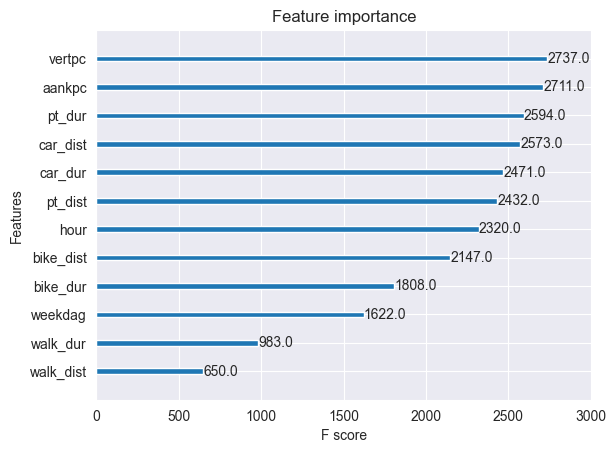

In [16]:
xgb.plot_importance(model, importance_type = 'weight') # other options available


In [23]:
y_pred = le.inverse_transform(list(y_pred))
y_valid = le.inverse_transform(list(y_valid))
cm = confusion_matrix(y_valid, y_pred)
cl = list(le.inverse_transform(model.classes_))
dddf = pd.DataFrame(cm, columns=cl, index=cl)
# sns.heatmap(dddf, annot=True, fmt='.0f')
print(classification_report(list(y_valid), list(y_pred)))

NameError: name 'sns' is not defined

In [25]:
#Model
#
model = xgb.XGBClassifier()
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
model.fit(X_train, y_train, sample_weight = sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [26]:
fel_pred = model.predict_proba(X_test)

In [36]:
finaldf = pd.concat([test_data, pd.DataFrame(fel_pred, columns=le.inverse_transform(model.classes_)).round(2).set_index(test_data.index)], axis = 1)

In [37]:
finaldf['pred'] = le.inverse_transform(model.predict(X_test))
finaldf

,tripid,carId,fuelLevel,time,lat,lon,geometry,prev_time,timedelta,prev_location,...,vertpc,aankpc,Bus/tram/metro,Fiets,Overig,Personenauto - bestuurder,Personenauto - passagier,Te voet,Trein,pred
0,0,853,38,2023-01-02 18:50:40,52.358633,4.859237,POINT (4.85924 52.35863),2023-01-02 17:29:36,0 days 01:21:04,POINT (4.88286 52.37315),...,1016,1054,0.13,0.49,0.12,0.02,0.06,0.18,0.0,Fiets
100023,100023,3861,51,2023-02-24 21:30:40,52.358823,4.920905,POINT (4.92091 52.35882),2023-02-24 21:22:08,0 days 00:08:32,POINT (4.91869 52.34938),...,1097,1092,0.03,0.52,0.04,0.02,0.04,0.35,0.0,Fiets
10004,10004,1187,96,2023-01-13 11:22:40,52.332980,4.914108,POINT (4.91411 52.33298),2023-01-13 10:46:24,0 days 00:36:16,POINT (4.87396 52.36492),...,1054,1096,0.44,0.23,0.15,0.09,0.07,0.01,0.0,Bus/tram/metro
100101,100101,3867,19,2023-02-22 07:28:00,52.375562,4.866955,POINT (4.86695 52.37556),2023-02-22 07:19:28,0 days 00:08:32,POINT (4.87437 52.37072),...,1053,1051,0.01,0.19,0.04,0.01,0.01,0.74,0.0,Te voet
100139,100139,3889,52,2023-02-21 17:36:00,52.361956,4.876053,POINT (4.87605 52.36196),2023-02-21 17:14:40,0 days 00:21:20,POINT (4.90360 52.36494),...,1018,1054,0.18,0.59,0.09,0.02,0.00,0.11,0.0,Fiets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99838,99838,3808,75,2023-02-27 17:18:56,52.352607,4.855997,POINT (4.85600 52.35261),2023-02-27 16:59:44,0 days 00:19:12,POINT (4.87210 52.39669),...,1013,1075,0.39,0.37,0.04,0.14,0.03,0.02,0.0,Bus/tram/metro
99876,99876,3834,88,2023-02-27 08:34:08,52.354490,4.893847,POINT (4.89385 52.35449),2023-02-27 08:23:28,0 days 00:10:40,POINT (4.87926 52.33178),...,1082,1073,0.15,0.40,0.28,0.08,0.08,0.01,0.0,Fiets
99904,99904,3841,28,2023-02-19 11:33:20,52.356524,4.841132,POINT (4.84113 52.35652),2023-02-19 11:09:52,0 days 00:23:28,POINT (4.88436 52.36615),...,1017,1062,0.21,0.28,0.18,0.06,0.02,0.26,0.0,Fiets
99924,99924,3841,67,2023-02-25 17:21:04,52.390913,4.855753,POINT (4.85575 52.39091),2023-02-25 16:55:28,0 days 00:25:36,POINT (4.88460 52.36111),...,1071,1014,0.29,0.51,0.05,0.06,0.06,0.03,0.0,Fiets


In [39]:
finaldf.pred.value_counts()

pred
Fiets                        4293
Te voet                      2105
Bus/tram/metro                547
Personenauto - passagier      122
Overig                        101
Personenauto - bestuurder      25
Trein                           4
Name: count, dtype: int64

In [41]:
finaldf[list(le.inverse_transform(model.classes_))].sum()

Bus/tram/metro                993.489990
Fiets                        2999.649902
Overig                        519.049988
Personenauto - bestuurder     347.429993
Personenauto - passagier      391.269989
Te voet                      1931.359863
Trein                           8.309999
dtype: float32

In [43]:
import matplotlib.pyplot as plt

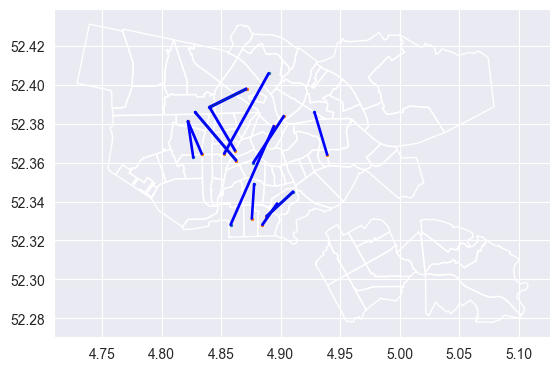

In [48]:
def plotjourneys(col, samples, finaldf = finaldf):
    best = finaldf[finaldf.pred == col]
    fig, ax = plt.subplots()
    PCs.plot(ax = ax, facecolor = 'None')

    trein = best.sample(samples)
    ax.scatter(trein.geometry.x, trein.geometry.y, s = 2)
    ax.scatter(trein.prev_location.x, trein.prev_location.y, s =2)

    for index, row in trein.iterrows():
        x = row['geometry'].x
        y = row['geometry'].y
        prev_x = row['prev_location'].x
        prev_y = row['prev_location'].y

        dx = x - prev_x
        dy = y - prev_y

        ax.arrow(prev_x, prev_y, dx, dy, head_width=0.0005, head_length=0.0005, fc='green', ec='blue')

plotjourneys('Personenauto - bestuurder', 12)

In [49]:
gr =finaldf.drop(['geometry', 'prev_location'], axis =1 ).groupby('pred').mean()
gr

,tripid,carId,fuelLevel,time,lat,lon,prev_time,timedelta,distancemoved,prev_fl,...,weekdag,vertpc,aankpc,Bus/tram/metro,Fiets,Overig,Personenauto - bestuurder,Personenauto - passagier,Te voet,Trein
pred,,,,,,,,,,,,,,,,,,,,,
Bus/tram/metro,132417.963437,3640.566728,58.888483,2023-03-05 12:38:25.020109824,52.363126,4.884882,2023-03-05 12:13:28.595978240,0 days 00:24:56.424131627,0.046148,61.703839,...,3.422303,inf,inf,0.443876,0.254643,0.095137,0.073894,0.082651,0.044095,0.004424
Fiets,130492.705101,3935.387142,56.780107,2023-03-03 18:23:24.989517824,52.362468,4.883918,2023-03-03 18:04:48.997903616,0 days 00:18:35.991614255,0.031124,58.004193,...,3.100396,inf,inf,0.143969,0.537349,0.079283,0.053222,0.054491,0.130177,0.000773
Overig,129166.851485,3993.237624,57.831683,2023-03-03 07:19:19.643564288,52.359640,4.872355,2023-03-03 06:56:00.633663488,0 days 00:23:19.009900990,0.042369,60.564356,...,3.138614,inf,inf,0.176535,0.236040,0.397525,0.062475,0.070297,0.054257,0.002475
Personenauto - bestuurder,141801.560000,3470.000000,65.880000,2023-03-10 01:16:16.319999744,52.363578,4.874663,2023-03-10 00:55:28.640000000,0 days 00:20:47.680000,0.031283,58.200000,...,4.680000,4288433243324372337802275760369565909920765575...,4132428843084404147456931846037739328137482506...,0.144800,0.217200,0.090000,0.360000,0.101200,0.082800,0.005200
Personenauto - passagier,128517.131148,3968.877049,57.352459,2023-03-02 05:24:59.262295040,52.348563,4.879241,2023-03-02 05:03:06.532786944,0 days 00:21:52.729508196,0.044635,58.418033,...,4.754098,inf,inf,0.165000,0.193770,0.080738,0.090410,0.425000,0.043279,0.001148
Te voet,128798.669834,3825.706413,56.289786,2023-03-03 05:53:30.366745856,52.362821,4.885942,2023-03-03 05:38:16.896436992,0 days 00:15:13.470308788,0.012194,56.220428,...,3.328266,inf,inf,0.042993,0.237387,0.035097,0.024622,0.024038,0.634461,0.000228
Trein,152884.250000,2552.750000,66.750000,2023-03-19 00:51:21.249999872,52.375884,4.887312,2023-03-19 00:08:40.249999872,0 days 00:42:41,0.056356,60.250000,...,4.000000,260776077530260.75,252775302535252.75,0.137500,0.227500,0.130000,0.090000,0.012500,0.005000,0.392500


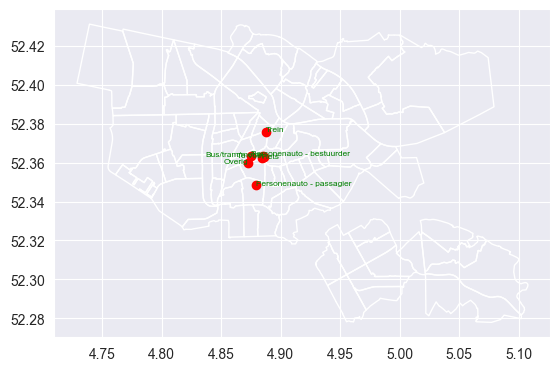

In [50]:
fig, ax = plt.subplots()
PCs.plot(ax=ax, facecolor='None')
# trein.plot(ax = ax)
ax.scatter(gr.lon, gr.lat, color='red')
has = ['right', 'left', 'right', 'left', 'left', 'right', 'left']
for i, txt in enumerate(gr.index):
    ax.annotate(txt, (gr.lon[i], gr.lat[i]), color='green', fontsize = 6, horizontalalignment = has[i])
# ax.scatter(gr.prev_lat, gr.prev_lon, color='blue')